### Spatial variation of house effect
Previously I fitted a Poisson mixed effect model with village and month as fixed effects as well as mosquito nets and number of residents. The random effects are observational-level overdispersion, yearly and among-house variations. Some analyses were run only on the wet season counts (response is the female count, both species combined). 

To further investigate the house effect and its spatial clustering (if any) I wanted to fit a similar model by changing it to a fixed effect with about 300 levels (houses). This also meant to estimate 300 additional parameters for each house rather than one overall variance estimate. The computer did not like this task and I was stuck. 

After some research I discovered a method to extract the approximate house effect from the existing mixed effect model. I am still reading about this. Since the house effect is the difference between the house mean and the overall mean (after controlling for other factors), it is possible to work it back by comparing the fitted and observed data points. Hence R calls it the "conditional mode". 

I think it is a good middle ground for our task. 

In [6]:
# LOAD R PACKAGES
require(compiler)
enableJIT(3)
setMKLthreads(20)
require(lme4)
require(lmerTest)
require(MASS)

# LOAD DATASET dat1
#setwd('variance/Florian')
load('Per house data PSC 2012 to 2019 polish2.RData')
#load('BF_weather.RData')
ls()

[1] 3

[1] "dat1"           "m_4C"           "overdispersion"

In [7]:
names(dat1)
names(BV_weather)

[1] "village"            "month.assigned"     "year.assigned"     
 [4] "monthyear.assigned" "day"                "month"             
 [7] "year"               "date.collection"    "site.id"           
[10] "longitude"          "latitude"           "room.id"           
[13] "num.persons"        "num.persons.remark" "mosquito.net"      
[16] "permanence"         "count.m"            "genotyped.m"       
[19] "col.m"              "gam.m"              "arab.m"            
[22] "count.f"            "genotyped.f"        "col.f"             
[25] "gam.f"              "arab.f"

ERROR: Error in eval(expr, envir, enclos): object 'BV_weather' not found


In [8]:
# THREE LEVELS OF PERSONS: None, Low, Hi
dat1$persons.status<-dat1$num.persons
dat1$persons.status[dat1$num.persons>3]<-'Hi'
dat1$persons.status[dat1$num.persons<=3]<-'Low'
dat1$persons.status[dat1$num.persons==0]<-'None'
dat1$persons.status<-factor(dat1$persons.status, levels=c('None', 'Low', 'Hi'))
overdispersion<-1:nrow(dat1)

In [9]:
#m_4C<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status, 
#             family='poisson', data=dat1, 
#             control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=3e4)))
#m_4C<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status, 
#             family='poisson', data=dat1, 
#             control=glmerControl(optimizer="bobyqa"))
#summary(m_4C)

In [10]:
load('m_4C.RData')
ls()

[1] "dat1"           "m_4C"           "overdispersion"

In [11]:
summary(m_4C)


Correlation matrix not shown by default, as p = 51 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned * village + mosquito.net + persons.status
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 16246.4  16573.1  -8069.2  16138.4     3079 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3859 -0.4312 -0.1184  0.1370  4.4419 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.2453   1.1159  
 site.id        (Intercept) 0.3395   0.5827  
 year.assigned  (Intercept) 0.1536   0.3919  
Number of obs: 3133, groups:  
overdispersion, 3133; site.id, 383; year.assigned, 6

Fixed effects:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                              -4.609421   0.891313  -5.171 2

In [12]:
# PUT ESTIMATED RANDOM EFFECTS INTO A DATA FRAME
s<-ranef(m_4C)$site.id
site.id.effect<-data.frame(site.id=rownames(s), effect=unlist(s), row.names=NULL)
nrow(site.id.effect)

# EXTRACT LAT LONG INFO (MANY DUPLICATED)
s1<-dat1[!duplicated(dat1[,9:11]), 9:11]
nrow(s1)

# MERGE LAT AND LONG
s2<-merge(site.id.effect, s1, by='site.id', all.x=T)
dim(s2)
head(s2)
rm(s); rm(s1);

[1] 383

[1] 386

[1] 383   4

site.id,effect,longitude,latitude
BF.BM.02.001,-0.13506934,-4.471190,11.23421
BF.BM.03.001,-0.57141247,-4.471004,11.23479
BF.BM.121.001,1.16913064,-4.472744,11.23510
BF.BM.13.001,0.57456159,-4.470798,11.23368
BF.BM.16.001,-0.15918438,-4.482247,11.24220
BF.BM.26.001,0.08437413,-4.484353,11.24241


#### Extracting "conditional mode" for each house
The function ranef() extracts the "conditional mode" for individual house effect. it also returns overdispersion and yearly effect as well but they are not our focus. I then append these estimates with coordinates info. 

Below I plot the histrogram of these house effect and it certainly looks like a bell curve. It is because the mixed effect model assumes normality on the random components (and if I fit it as a fixed effect then no assumption is made on these 300 house levels). I believe I am still able to preserve the order and relative strengh of the house effect. 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.051553 -0.208136 -0.012997  0.004665  0.218529  1.187922 

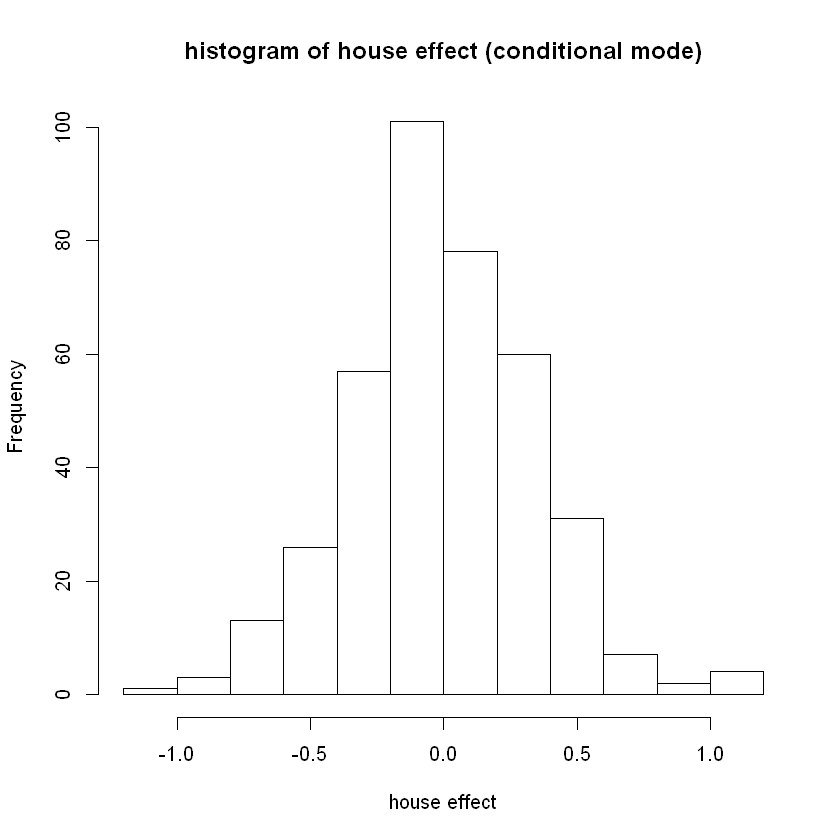

In [13]:
hist(s2$effect, xlab='house effect', main='histogram of house effect (conditional mode)')
# OVERALL SUMMARY ON HOUSE EFFECT
summary(s2$effect)

#### Heatmap
After studying the summary of the house effect I decide to assign them into 51 bins (for colouring) with equal width of 0.05. A heatmap (and some zoom-ins) is produced. Each dot is a house, and the more red the higher effect the house has. 

In [15]:
bounds<-seq(-1.15, 1.25, 0.05)
length(bounds)
# ASSIGN EFFECTS INTO BINS
# PUT EFFECTS INTO BINS
bins<-cut(s2$effect, breaks=bounds, labels=F)
# LARGE EFFECT SMALL BINS NUMBER AND MORE RED
bins<-length(bounds)-bins
#bins
bins[57]
s2$effect[57]

[1] 49

[1] 41

[1] -0.7514082

In [16]:
# RANK THE HOUSE EFFECT IN DESCENDING ORDER AND ASSIGN COLOUR CODE (LARGE IS RED)
colour_map<-heat.colors(length(bounds))
s2$col<-colour_map[bins]
rm(bins); rm(bounds);

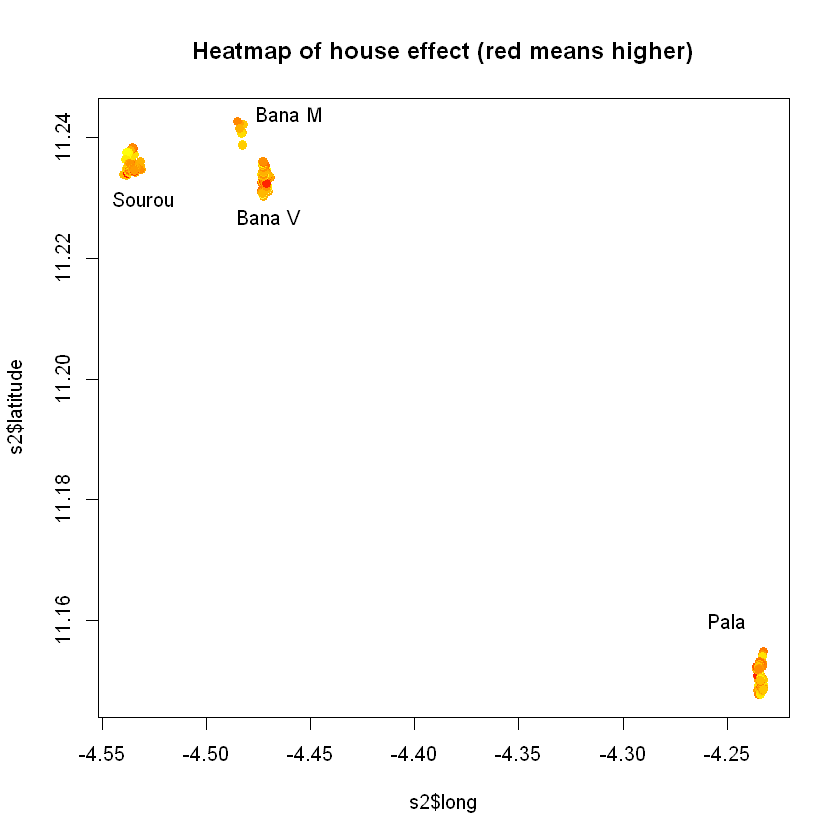

In [17]:
# TOPRIGHT IS SOUROU, THEN BANA M, BANA V, BOTTOM IS PALA
# ACCORDING TO GOOGLE MAP
plot(x=s2$long, y=s2$latitude, pch=16, col=s2$col, 
    main='Heatmap of house effect (red means higher)')
text(-4.53, 11.23, 'Sourou')
text(-4.46, 11.244, 'Bana M')
text(-4.47, 11.227, 'Bana V')
text(-4.25, 11.16, 'Pala')

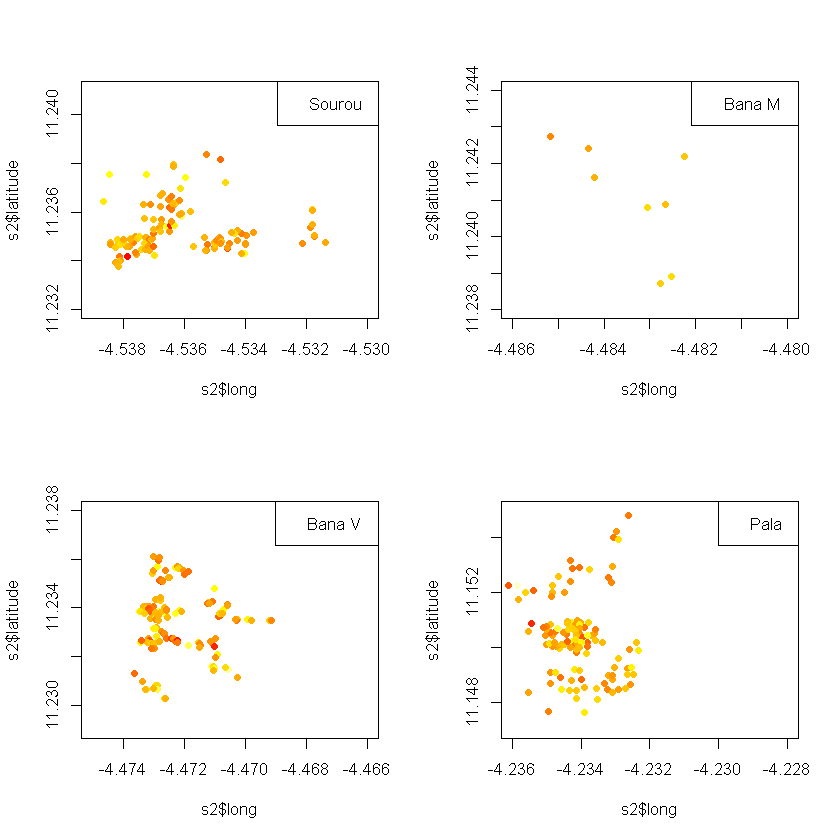

In [18]:
# ZOOM IN
par(mfrow=c(2,2))
#
plot(x=s2$long, y=s2$latitude, 
     xlim=c(-4.539, -4.539+0.009), ylim=c(11.232,11.232+0.009),
     pch=16, col=s2$col)
legend('topright', legend='Sourou')
#
plot(x=s2$long, y=s2$latitude, 
     xlim=c(-4.486, -4.486+0.006), ylim=c(11.238,11.238+0.006),
     pch=16, col=s2$col)
legend('topright', legend='Bana M')
# 
plot(x=s2$long, y=s2$latitude, 
     xlim=c(-4.475, -4.475+0.009), ylim=c(11.229,11.229+0.009),
     pch=16, col=s2$col)
legend('topright', legend='Bana V')
#
plot(x=s2$long, y=s2$latitude, 
     xlim=c(-4.236, -4.236+0.008), ylim=c(11.147, 11.147+0.008),
     pch=16, col=s2$col)
legend('topright', legend='Pala')

##### All data points vs wet season only
The scatterplot below compares the house effects when using all data points and using wet season count only. The calculation is not shown here but you expect a very high correlation. 

site.id,effect.x,effect.y
BF.BM.02.001,0.01698915,-0.1350693
BF.BM.02.001,0.01698915,-0.1350693
BF.BM.03.001,-0.44719364,-0.5714125
BF.BM.03.001,-0.44719364,-0.5714125
BF.BM.121.001,1.22519805,1.1691306
BF.BM.13.001,0.75194327,0.5745616


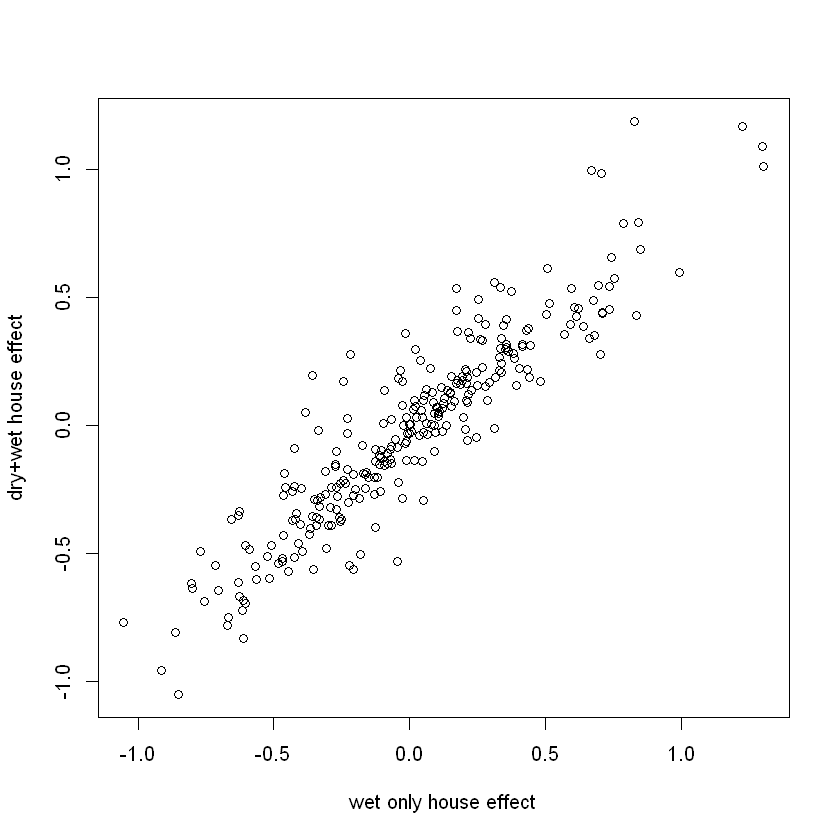

In [22]:
# CORR BETWEEN THE TWO?
s<-merge(s2[,1:2], s2_all[,1:2], by='site.id', all=T)
head(s)
plot(s$effect.x, s$effect.y, xlab='wet only house effect', ylab='dry+wet house effect')

##### Randomisation test of house effect
Randomisation is a simple and intuitive way to see whether the observed pattern is different from "null". Here I calculate all pairwise abs(diff of house effect) and distance (based on lat and long), and plot one against another. 

If there is spatial clustering then those house pairs with shorter distance will have similar house effects hence smaller absolute differences. Hence the plot will have a positive slope. The null is expected to have a slope of 0. 

The histogram is the "null distribution" generated by randomisation, and the red vertical line indicates the observed slope. 

In [19]:
require(inline)
body<-"
    int len=LENGTH(effect);
    SEXP r=PROTECT(allocMatrix(REALSXP, len, len));
    double *h_effect; h_effect=REAL(effect);
    double *h_r; h_r=REAL(r);
    for (int i=0; i<len; i++)
    {
        for (int j=i; j<len; j++)
        {
            double temp_r=fabs(h_effect[j]-h_effect[i]);
            h_r[i*len+j]=temp_r;
            h_r[j*len+i]=temp_r;
        }
    }
    UNPROTECT(1);
    return r;
"
cal_effect<-cfunction(sig=c(effect='numeric'),  
                          body=body, includes='#include <math.h>', 
                          language='C', convention='.Call')
# DISTANCE MATRIX
body<-"
    int len=LENGTH(lat);
    SEXP dist=PROTECT(allocMatrix(REALSXP, len, len));
    double *h_lat; double *h_lon; 
    h_lat=REAL(lat); h_lon=REAL(lon); 
    double *h_dist; h_dist=REAL(dist);
    for (int i=0; i<len; i++)
    {
        for (int j=i; j<len; j++)
        {
            double temp_dist=(h_lat[j]-h_lat[i])*(h_lat[j]-h_lat[i])+(h_lon[j]-h_lon[i])*(h_lon[j]-h_lon[i]);
            temp_dist=sqrt(temp_dist);
            h_dist[i*len+j]=temp_dist;
            h_dist[j*len+i]=temp_dist;
        }
    }
    UNPROTECT(1);
    return dist;
"
cal_dist<-cfunction(sig=c(lat='numeric', lon='numeric'),  
                          body=body, 
                          language='C', convention='.Call')

Loading required package: inline


In [20]:
randomisation_test<-function(s2, village='BV', times=1000)
{
    f1<-function(temp_s2)
    {
        temp_r<-cal_effect(temp_s2$effect)
        temp_r<-temp_r[lower.tri(temp_r, diag=F)]
        temp_r<-as.vector(temp_r)
        temp_dist<-cal_dist(temp_s2$lat, temp_s2$lon)
        temp_dist<-temp_dist[lower.tri(temp_dist, diag=F)]
        temp_dist<-as.vector(temp_dist)
        m<-lm(temp_r~temp_dist)
        return(m$coef[2])
    }
    # CHOOSE VILLAGE
    temp<-substr(s2$site.id, 4, 5)
    temp_s2<-s2[temp==village,]
    # THE OBSERVED
    obs<-f1(temp_s2)
    # RANDOMISE
    ran<-rep(NA, times)
    for (i in 1:times)
    {
        new_s2<-data.frame(effect=sample(temp_s2$effect), lat=temp_s2$lat, long=temp_s2$long)
        ran[i]<-f1(new_s2)
    }
    return(list(obs=obs, ran=ran))
}

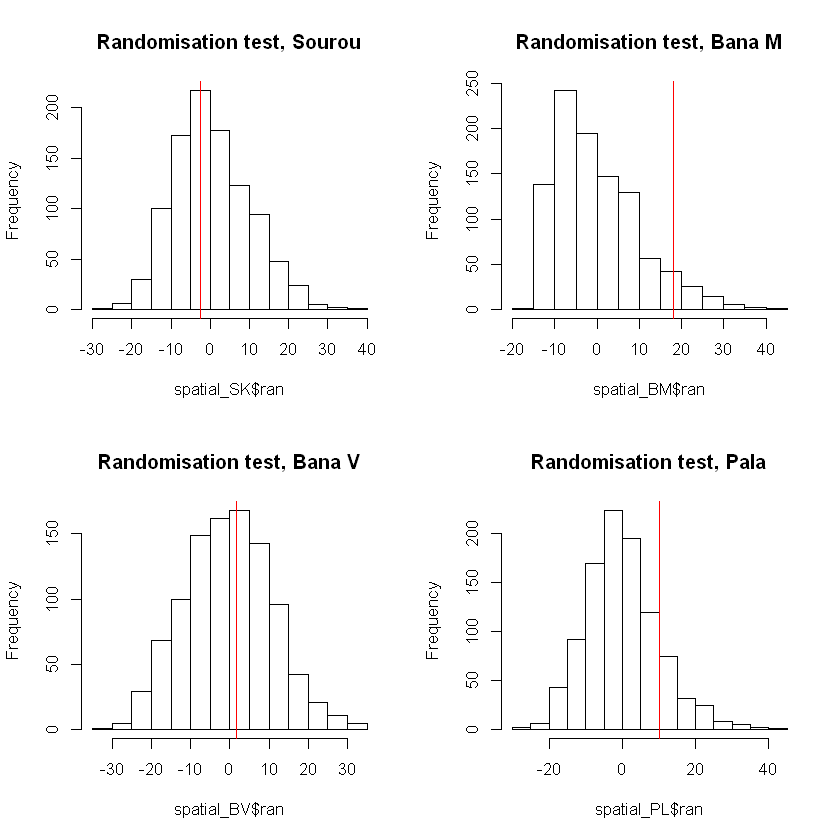

In [25]:
par(mfrow=c(2,2))
spatial_SK<-randomisation_test(s2, village='SK', times=1000)
hist(spatial_SK$ran, main='Randomisation test, Sourou')
abline(v=spatial_SK$obs, col='red')

spatial_BM<-randomisation_test(s2, village='BM', times=1000)
hist(spatial_BM$ran, main='Randomisation test, Bana M')
abline(v=spatial_BM$obs, col='red')

spatial_BV<-randomisation_test(s2, village='BV', times=1000)
hist(spatial_BV$ran, main='Randomisation test, Bana V')
abline(v=spatial_BV$obs, col='red')

spatial_PL<-randomisation_test(s2, village='PL', times=1000)
hist(spatial_PL$ran, main='Randomisation test, Pala')
abline(v=spatial_PL$obs, col='red')

I think the randomisation tests also suggest there are no strong spatial correlation in our house effects. The null distribution of Bana M is a bit strange perhaps due to the small house number in the region. 

##### Moran I test
Another way to test for spatial (auto-)correlation is via the Moran's I test. I have been following the tutorial here: 
https://hughst.github.io/week-4/

And luckily there is an R package for this test. 

In [26]:
require(ape)

moran<-function(s2, village='BV')
{
    temp_s2<-s2[substr(s2$site.id, 4, 5)==village,]
    temp<-is.na(temp_s2)
    temp<-apply(temp, 1, sum)
    temp_s2<-temp_s2[temp==0,]
    temp_dist<-cal_dist(temp_s2$lat, temp_s2$lon)
    # INVERT DIST. IF INVERTED DIST =Inf (DIST=0) THEN CODED AS 0
    temp_dist_inv<-1/temp_dist
    temp_dist_inv[temp_dist_inv==Inf]<-0
    return(Moran.I(temp_s2$effect, temp_dist_inv, na.rm=T))
}

Loading required package: ape


In [27]:
# SOUROU
moran(s2, village='SK')

$observed
[1] -0.00105627

$expected
[1] -0.00877193

$sd
[1] 0.02169538

$p.value
[1] 0.7221131

In [28]:
# BANA M
moran(s2, village='BM')

$observed
[1] -0.07087254

$expected
[1] -0.09090909

$sd
[1] 0.1368365

$p.value
[1] 0.8835844

In [29]:
# BANA V
moran(s2, village='BV')

$observed
[1] 0.06201318

$expected
[1] -0.008196721

$sd
[1] 0.02138183

$p.value
[1] 0.001024811

In [30]:
# PALA
moran(s2, village='PL')

$observed
[1] -0.004514561

$expected
[1] -0.007692308

$sd
[1] 0.01084757

$p.value
[1] 0.7695638

The Moran's I test says Bana V has a significant spatial correlation. 